In [1]:
import KeplerFunctions as KeplerFinder
import importlib
import multiprocessing.pool
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.timeseries import BoxLeastSquares
import scipy.signal
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from lightkurve import search_lightcurve
from scipy.optimize import minimize
import multiprocessing
from scipy.signal  import medfilt
from lightkurve.lightcurve import TessLightCurve
import glob


importlib.reload(KeplerFinder)

<module 'KeplerFunctions' from '/home/olivermcevoy/Documents/PlanetFinder/KeplerFunctions.py'>

In [2]:
def fetch_kepler_data_and_stellar_info(target,filter_type = 'savgol'):
    search_result = search_lightcurve(target, mission="Kepler")
    lc_collection = search_result.download_all()

    time, flux, error = np.array([]), np.array([]), np.array([])
    quart = 0
    for lc in lc_collection:
        print(f"Downloading light curve segment {quart + 1} of {len(lc_collection)}", end='\r')
        quart += 1

        lc_data = lc.remove_nans()
        tmptime = lc_data.time.value
        tmpflux = lc_data.flux.value
        tmperror = lc_data.flux_err.value

        array_size = len(tmpflux)
        window_length = min(51, array_size - (array_size % 2 == 0))

        if window_length > 2:
            if filter_type == 'savgol':
                normaliser = savgol_filter(tmpflux, window_length=window_length, polyorder=3)
            elif filter_type == 'medfilt':
                tmpflux = tmpflux.astype(np.float64)  # Convert to f64 for medfilt
                normaliser = medfilt(tmpflux, kernel_size=51)
        else:
            normaliser = np.ones_like(tmpflux)
        

        time = np.append(time, tmptime)
        flux = np.append(flux, tmpflux / normaliser)
        error = np.append(error, tmperror / normaliser)

    df = pd.DataFrame({"time": time, "flux": flux, "error": error})
    mean_flux = np.mean(flux)
    std_flux = np.std(flux)
    df = df[(df["flux"] <= mean_flux + 3 * std_flux) & (df["flux"] >= mean_flux - 8 * std_flux)]

    # Fetch stellar information from the light curve metadata
    if len(lc_collection) > 0:
        star_data = lc_collection[0].meta
        stellar_params = {
            "stellar_radius": star_data.get("RADIUS", np.nan),  # Stellar radius in solar radii
            "temperature": star_data.get("TEFF", np.nan),   # Stellar effective temperature
        }
    else:
        stellar_params = None

    return df, stellar_params

target = 'Kepler-1912'

kepler_dataframe , _ = fetch_kepler_data_and_stellar_info(target,'medfilt')

In [32]:
target = 'Kepler-1912'

kepler_dataframe , _ = fetch_kepler_data_and_stellar_info(target,'medfilt')


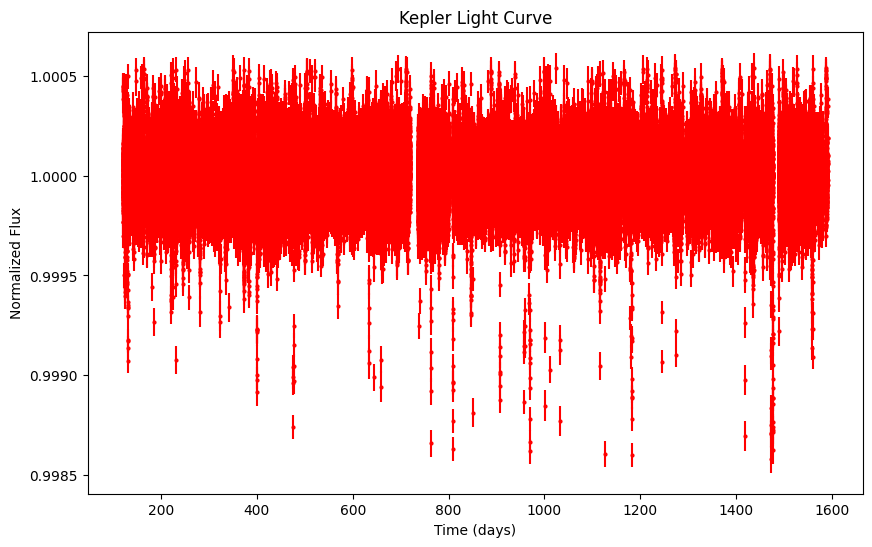

In [33]:
KeplerFinder.plot_light_curve(kepler_dataframe['time'],kepler_dataframe['flux'],kepler_dataframe['error'])

In [27]:
kepler_dataframe

,time,flux,error
1,1274.180570,1.000912,0.001005
2,1274.201004,1.002449,0.001004
3,1274.221438,1.002052,0.001004
4,1274.241872,1.001287,0.001004
5,1274.262306,1.000781,0.001004
...,...,...,...
26901,1590.858857,1.002229,0.000878
26902,1590.879291,1.002867,0.000878
26903,1590.899725,1.003038,0.000879
26904,1590.920159,1.003030,0.000879
